<a href="https://colab.research.google.com/github/HuaichenOvO/ML/blob/main/CSC3180_prepreocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests



DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')): 
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [ ]:
# !pip install d2l
# !pip install matplotlib==3.0.0
# !pip install --upgrade mxnet
# !pip install autogluon
# !pip install torch
# # !pip install d2l.torch

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

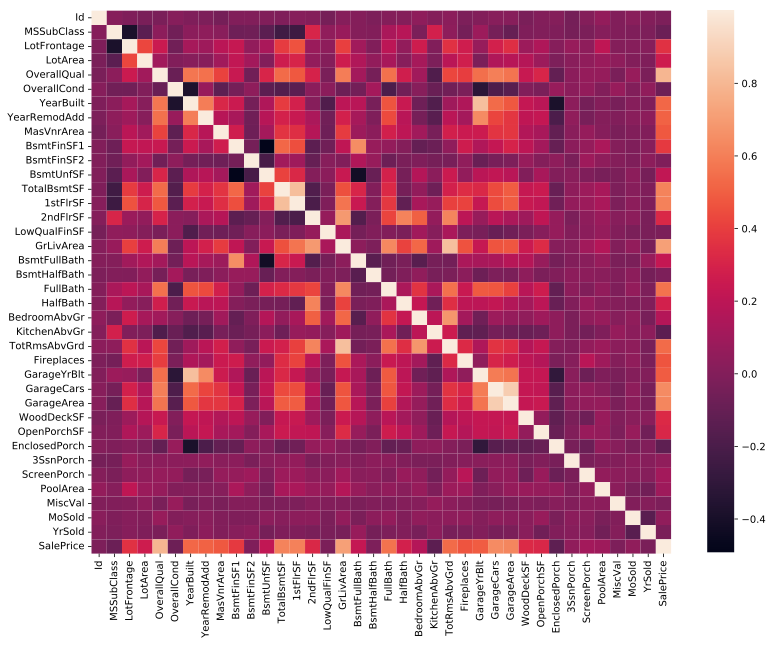

In [ ]:
"""
数据可视化 了解大概印象
"""

# train_data.info()
# train_data.head(2)
# train_data['SalePrice']

# 热区图
corrmat = train_data.corr()
plt.subplots(figsize = (13,10))
sns.heatmap(corrmat)

In [ ]:
"""
数据insight
"""
# train_data.describe().T
# train_data.describe(include='object').T

corr = train_data.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(corr,annot=True)

corr_arr=corr["SalePrice"].sort_values(ascending=False)
corr_arr=pd.DataFrame(corr_arr)
corr_arr.head(11)



,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [ ]:
"""
数据清洗：去除无关attribute
"""

# train_data.drop(columns=['Id'],axis=1,inplace=True)
# train_data.drop(columns=['Id'],axis=1,inplace=True)

'\n数据清洗：去除无关attribute\n'

In [ ]:
"""
预处理
1. 将已经是数值化的数据normalize
2. fill object value by None without null value.
"""
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

train = deepcopy(train_data)
test = deepcopy(test_data)

def myPreprocessing(data_set):
    # 1. 标准化数值类型的数据
    # after normalisation, the mean disappear, 
    # so we can set the null space to 0.
    numeric_features = data_set.dtypes[data_set.dtypes != 'object'].index
    data_set[numeric_features] = data_set[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    data_set[numeric_features] = data_set[numeric_features].fillna(0)

    # 2. 将非数值类型的数据encode
    object_cols=data_set.select_dtypes(include='object')
    le = LabelEncoder()
    for i in object_cols:
        data_set[i]=le.fit_transform(data_set[i])

    data_set.astype(float)


# split train_x and train_y
myPreprocessing(train)
NonNN_X = train.drop(['Id','SalePrice'], axis = 1)
NonNN_y = train[['SalePrice']]

x_train, x_test, y_train, y_test = train_test_split(NonNN_X, NonNN_y, test_size = 0.2, random_state= 42)

# there is no null data left
print(train.shape)
# print(y.isnull().sum().max())


print(train.head(5))
# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1460, 81)
         Id  MSSubClass  MSZoning  LotFrontage   LotArea  Street  Alley  \
0 -1.730272    0.073350         3    -0.207948 -0.207071       1      2   
1 -1.727900   -0.872264         3     0.409724 -0.091855       1      2   
2 -1.725528    0.073350         3    -0.084413  0.073455       1      2   
3 -1.723156    0.309753         3    -0.413838 -0.096864       1      2   
4 -1.720785    0.073350         3     0.574436  0.375020       1      2   

   LotShape  LandContour  Utilities  ...  PoolArea  PoolQC  Fence  \
0         3            3          0  ... -0.068668       3      4   
1         3            3          0  ... -0.068668       3      4   
2         0            3          0  ... -0.068668       3      4   
3         0            3          0  ... -0.068668       3      4   
4         0            3          0  ... -0.068668       3      4   

   MiscFeature   MiscVal    MoSold    YrSold  SaleType  SaleCondition  \
0            4 -0.087658 -1.598563  0.138730      

In [ ]:
"""
神经网络需要另一套预处理
"""

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# after normalisation, the mean disappear, so we can set the null space to 0.
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.astype(float)
all_features.shape
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=d2l.float32)
NonN_train_labels = np.log(torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32))
NN_train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

In [ ]:
"""
K-fold
"""

loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k


   

In [ ]:
# 对 test 做同样的处理

myPreprocessing(test)

test.shape
# print(test.isnull().sum().max())

# print(test.head(10))

(1459, 80)

In [ ]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

In [ ]:
"""
Linear Regression
"""

from sklearn.linear_model import LinearRegression

k = 5
lin_rmse_arr = []
for i in range(k):
    
    X_train, y_train, X_val, y_val = get_k_fold_data(k,i,train_features,NonN_train_labels)

    regressor = LinearRegression()
    fit = regressor.fit(X_train, y_train)
    y_pred = fit.predict(X_val)

    RMSE_score = mean_squared_error(y_val, y_pred, squared = False)
    lin_rmse_arr.append(RMSE_score)
    print(RMSE_score)

# plot_graph(lin_rmse_arr)

3.7253234
2.2083502
0.16913046
1.6825513
2.6392121


In [ ]:
"""
Catboost Regression 
"""

from catboost import CatBoostRegressor

k = 5
Cat_rmse_arr = []
for i in range(k):
    X_train, y_train, X_val, y_val = get_k_fold_data(5,i,train_features,NonN_train_labels)
    X_train = pd.DataFrame(X_train.numpy())
    y_train = pd.DataFrame(y_train.numpy())
    X_val = pd.DataFrame(X_val.numpy())
    y_val = pd.DataFrame(y_val.numpy())

    catb_reg = CatBoostRegressor(iterations=3500,verbose=1000)
    fit = catb_reg.fit(X_train, y_train)
    y_pred = fit.predict(X_val)

    RMSE_score = mean_squared_error(y_val, y_pred, squared = False)
    Cat_rmse_arr.append(RMSE_score)
    print(str(i), "- fold ", "RMSE_score = ", RMSE_score)
    print('--'*10)

# plot_graph(Cat_rmse_arr)

Learning rate set to 0.015153
0:	learn: 0.3986884	total: 13.3ms	remaining: 46.7s
1000:	learn: 0.0723611	total: 5.78s	remaining: 14.4s
2000:	learn: 0.0473239	total: 11.5s	remaining: 8.63s
3000:	learn: 0.0324651	total: 17.2s	remaining: 2.87s
3499:	learn: 0.0272625	total: 20.1s	remaining: 0us
0 - fold  RMSE_score =  0.10496598130177286
--------------------
Learning rate set to 0.015153
0:	learn: 0.3890160	total: 6.37ms	remaining: 22.3s
1000:	learn: 0.0713011	total: 5.72s	remaining: 14.3s
2000:	learn: 0.0453838	total: 11.6s	remaining: 8.7s
3000:	learn: 0.0300627	total: 17.4s	remaining: 2.9s
3499:	learn: 0.0251807	total: 20.4s	remaining: 0us
1 - fold  RMSE_score =  0.13519960620261143
--------------------
Learning rate set to 0.015153
0:	learn: 0.3929101	total: 6.32ms	remaining: 22.1s
1000:	learn: 0.0675876	total: 5.84s	remaining: 14.6s
2000:	learn: 0.0428006	total: 11.7s	remaining: 8.77s
3000:	learn: 0.0289578	total: 17.6s	remaining: 2.92s
3499:	learn: 0.0242216	total: 20.5s	remaining: 0us

In [ ]:
"""
XGBoost Regression 
"""


from xgboost import XGBRegressor


k = 5
XGB_rmse_arr = []
for i in range(k):
    X_train, y_train, X_val, y_val = get_k_fold_data(5,i,train_features,NonN_train_labels)
    X_train = pd.DataFrame(X_train.numpy())
    y_train = pd.DataFrame(y_train.numpy())
    X_val = pd.DataFrame(X_val.numpy())
    y_val = pd.DataFrame(y_val.numpy())

    xgb_reg = XGBRegressor(n_estimators=3000, learning_rate=0.005)
    fit = xgb_reg.fit(X_train, y_train)
    y_pred = fit.predict(X_val)

    RMSE_score = mean_squared_error(y_val, y_pred, squared = False)
    XGB_rmse_arr.append(RMSE_score)
    print(str(i), "- fold ", "RMSE_score = ", RMSE_score)
    print('--'*10)

# plot_graph(XGB_rmse_arr)

0 - fold  RMSE_score =  0.114501305
--------------------
1 - fold  RMSE_score =  0.14088348
--------------------
2 - fold  RMSE_score =  0.13448845
--------------------
3 - fold  RMSE_score =  0.12526934
--------------------
4 - fold  RMSE_score =  0.129139
--------------------


In [ ]:
"""
Random Forest Regression 
"""

from sklearn.ensemble import RandomForestRegressor

k = 5
RF_rmse_arr = []
for i in range(k):

    X_train, y_train, X_val, y_val = get_k_fold_data(k,i,train_features,NonN_train_labels)

    forest = RandomForestRegressor().fit(X_train, y_train)
    y_pred = forest.predict(X_val)
    RF_rmse_arr.append(RMSE_score)
    RMSE_score = mean_squared_error(y_val, y_pred, squared = False)
    print(RMSE_score)

0.1385881054198832
0.1544400761190362
0.14417495105530048
0.12797134742399563
0.14885384869257168


In [ ]:
"""
KNN Regression 
"""

from sklearn.neighbors import KNeighborsRegressor

k = 5
KNN_rmse_arr = []
for i in range(k):

    X_train, y_train, X_val, y_val = get_k_fold_data(k,i,train_features,NonN_train_labels)

    knn_reg = KNeighborsRegressor().fit(X_train, y_train)
    y_pred = knn_reg.predict(X_val)
    KNN_rmse_arr.append(RMSE_score)
    RMSE_score = mean_squared_error(y_val, y_pred, squared = False)
    print(RMSE_score)

0.17106463
0.1880205
0.17245041
0.16007072
0.1762225


In [ ]:
"""
Gaussian Regression 
"""
from sklearn.gaussian_process import GaussianProcessRegressor

k = 5
GS_rmse_arr = []
for i in range(k):

    X_train, y_train, X_val, y_val = get_k_fold_data(k,i,train_features,NonN_train_labels)

    g_reg = GaussianProcessRegressor().fit(X_train, y_train)
    y_pred = g_reg.predict(X_val)
    GS_rmse_arr.append(RMSE_score)
    RMSE_score = mean_squared_error(y_val, y_pred, squared = False)
    print(RMSE_score)

11.919610737290768
11.976347781060165
11.906844852807293
11.865651753886436
11.906476833420092


In [ ]:
"""
Linear Neuron Network
"""

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, NN_train_labels, num_epochs, lr,
                          weight_decay, batch_size)


print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')


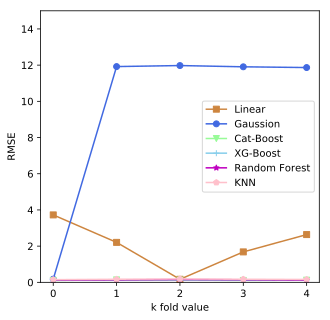

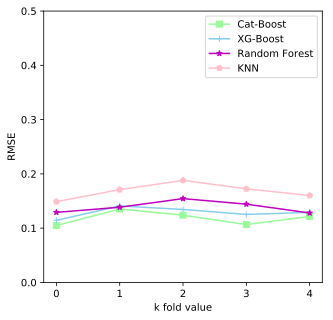

In [ ]:
from matplotlib.pyplot import MultipleLocator


plt.figure(figsize=(5, 5))
x = [0,1,2,3,4] # x-axis
plt.plot(x,lin_rmse_arr,'s-',color = 'peru',label="Linear") # s-:方形
plt.plot(x,GS_rmse_arr,'o-',color = 'royalblue',label="Gaussion")
plt.plot(x,Cat_rmse_arr,'v-',color = 'palegreen',label="Cat-Boost")
plt.plot(x,XGB_rmse_arr,'+-',color = 'skyblue',label="XG-Boost")
plt.plot(x,RF_rmse_arr,'*-',color = 'm',label="Random Forest")
plt.plot(x,KNN_rmse_arr,'p-',color = 'pink',label="KNN")
plt.ylim((0, 15))
plt.legend(loc = "best") #图例
plt.xlabel("k fold value")
plt.ylabel("RMSE")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show() 


plt.figure(figsize=(5, 5))
x = [0,1,2,3,4] # x-axis
plt.plot(x,Cat_rmse_arr,'s-',color = 'palegreen',label="Cat-Boost")
plt.plot(x,XGB_rmse_arr,'+-',color = 'skyblue',label="XG-Boost")
plt.plot(x,RF_rmse_arr,'*-',color = 'm',label="Random Forest")
plt.plot(x,KNN_rmse_arr,'p-',color = 'pink',label="KNN")
plt.ylim((0, 0.5))
plt.legend(loc = "best") #图例
plt.xlabel("k fold value")
plt.ylabel("RMSE")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show() 
